In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import weibull_min
from scipy.signal import spectrogram
import networkx as nx
import pandas as pd
import bisect
import seaborn as sns
from sympy import symbols, solve
import json


In [15]:
#Fixed parameters
sensitivity_steps = 6 #Number of parameter values scanned for sensitivity parameter specified below
simulations = 1
annual_decisions = 2 #Number of times an agent is evaluating strategy on average
households = 100
time = 100
mu_farm = 163.4
farm_k = 0.808 #Shape factor for farming income distribution (Weibull)
alpha = 0.9 #Proportion of full farm income that is still earned by households engaging in migration
cost_farm = 170

mu_migrate = 594.8
var_migrate = 998.2
cost_migrate = 50

beta = 0.25 #Proportion of income that is shared in collective
p_drought = 0.01

utility_function = 'Altruistic'

risk_factor = 0.5
altruism_factor = 0.5
sel_strength = 0.01 #Strength of selection effect
mutation_rate=0.001

In [3]:
#Define drought and non-drought portions of farming income distribution

def farm_drought(mu_farm, farm_k, p_drought):
    
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))

    income_distribution = scale * np.random.weibull(farm_k, size=1000)
    sorted_income = list(np.sort(income_distribution))
    
    drought_threshold = int(p_drought * len(sorted_income))
    nondrought_incomes = sorted_income[drought_threshold:len(sorted_income)]
    
    if p_drought == 0:
        drought_incomes = nondrought_incomes
    else:
        drought_incomes = sorted_income[0:drought_threshold]
    
    
    mu_farm_drought = np.average(drought_incomes)
    mu_farm_nd = np.average(nondrought_incomes)
    
    var_drought = np.var(drought_incomes)
    var_nd = np.var(nondrought_incomes)
    
    return mu_farm_drought, mu_farm_nd, var_drought, var_nd
    
#Calculate variance from Weibull distribution parameters

def wei_var(mu, k):
    scale = (mu_farm / math.gamma(1 + 1 / farm_k))
    variance = scale ** 2 * (math.gamma(1 + 2 / farm_k) - (math.gamma(1 + 1 / farm_k)) ** 2)
    
    return variance


In [4]:
# Calculate expected income from strategy options as a function of strategy distribution

def income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought):
    
    mu_farm_drought, mu_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[0:2]
    
    #Income generated by own household
    farm_income = {'Farm': mu_farm, 
                     'FarmMigrate': mu_farm * alpha, 
                     'Farm+Share': mu_farm, 
                     'FarmMigrate+Share': mu_farm * alpha, 
                     'Farm+Ins': mu_farm_nd, 
                     'FarmMigrate+Ins': mu_farm_nd * alpha, 
                     'Farm+Share+Ins': mu_farm_nd, 
                     'FarmMigrate+Share+Ins': mu_farm_nd * alpha}
    
    remittances = {'Farm': 0, 
                   'FarmMigrate': mu_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': mu_migrate, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': mu_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': mu_migrate}
    
    shared_pool = 0
    shared_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            shared_pool += beta * frequency_dist[-1][item] * (farm_income[item] + remittances[item])
            shared_dist += frequency_dist[-1][item]
    
    if shared_dist == 0:
        household_share = 0
    else:
        household_share = shared_pool / shared_dist
        
    shared_income_received = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': household_share, 
                   'FarmMigrate+Share': household_share, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': household_share, 
                   'FarmMigrate+Share+Ins': household_share}
    
    costs = {'Farm': cost_farm, 
            'FarmMigrate': cost_farm + cost_migrate, 
            'Farm+Share': cost_farm + beta * (farm_income['Farm+Share'] + remittances['Farm+Share']), 
            'FarmMigrate+Share': cost_farm + cost_migrate + beta * (farm_income['FarmMigrate+Share'] + remittances['FarmMigrate+Share']), 
            'Farm+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought), 
            'FarmMigrate+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought), 
            'Farm+Share+Ins': cost_farm + p_drought * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['Farm+Share+Ins'] + remittances['Farm+Share+Ins']), 
            'FarmMigrate+Share+Ins': cost_farm + cost_migrate + p_drought * alpha * (mu_farm_nd - mu_farm_drought) + beta * (farm_income['FarmMigrate+Share+Ins'] + remittances['FarmMigrate+Share+Ins'])}
    
    expected_payoffs = {}
    for item in strategy_names:
        expected_payoffs[item] = farm_income[item] + remittances[item] + shared_income_received[item] - costs[item]
    
    return expected_payoffs
        

In [6]:
#Variance calculation

def variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names):
    
    var_farm = wei_var(mu_farm, farm_k)
    var_farm_d, var_farm_nd = farm_drought(mu_farm, farm_k, p_drought)[2:4]
    
    variance = {'Farm': var_farm, 
                   'FarmMigrate': alpha * var_farm + var_migrate, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': (1 - p_drought) * var_farm_nd + p_drought * var_farm_d, 
                   'FarmMigrate+Ins': alpha * ((1 - p_drought) * var_farm_nd + p_drought * var_farm_d) + var_migrate, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    #Calculating variance of shared pool
    var_pool_num = 0
    pool_dist = 0
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            var_pool_num += beta * frequency_dist[-1][item] * variance[equivalent]
            pool_dist += frequency_dist[-1][item]
            
    var_pool = var_pool_num / pool_dist
    
    for item in strategy_names:
        if 'Share' in item:
            equivalent = item.replace('+Share', '')
            variance[item] = (1 - beta) * variance[equivalent] + var_pool
            

    return variance
            

In [7]:
# Calculation of homo economicus utility
def utility_calc(strategy_names, income, risk_factor, variance):
    
    utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
    
    for item in strategy_names:
        utilities[item] = income[item] - risk_factor * math.sqrt(variance[item])
    
    return utilities

In [8]:
#Calculation of altruism utility function

#Need to do 8x8 matrix where we calculate the new distribution once for the whole timestep (rather than each time we go to a new agent)

def altruistic_util(prior_strategies, households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor):
    
    altruistic_matrix = {'Farm': {}, 
                   'FarmMigrate': {}, 
                   'Farm+Share': {}, 
                   'FarmMigrate+Share': {}, 
                   'Farm+Ins': {}, 
                   'FarmMigrate+Ins': {}, 
                   'Farm+Share+Ins': {}, 
                   'FarmMigrate+Share+Ins': {}}
    
    strategy_names = altruistic_matrix.keys()
    

    #Updating potential frequency distributions based on household switching to another strategy
    for strategy in strategy_names:
        #print('For current household strategy:', strategy)
        altruistic_utilities = {'Farm': 0, 
                   'FarmMigrate': 0, 
                   'Farm+Share': 0, 
                   'FarmMigrate+Share': 0, 
                   'Farm+Ins': 0, 
                   'FarmMigrate+Ins': 0, 
                   'Farm+Share+Ins': 0, 
                   'FarmMigrate+Share+Ins': 0} 
        
        for name in strategy_names:
            #print('Switching to strategy:', name)
            base_strategies = {'Farm': 0, 
                       'FarmMigrate': 0, 
                       'Farm+Share': 0, 
                       'FarmMigrate+Share': 0, 
                       'Farm+Ins': 0, 
                       'FarmMigrate+Ins': 0, 
                       'Farm+Share+Ins': 0, 
                       'FarmMigrate+Share+Ins': 0} 
            
            for item in strategy_names:
                base_strategies[item] = prior_strategies[item]
            #print('Initial distribution is:', base_strategies)   
            potential_dist = []        
            potential_dist.append(base_strategies)
            potential_dist.append(base_strategies)
           
            #Adjust strategy distributions based on one household switching to the strategy "name"
            if name != strategy and base_strategies[strategy] != 0:
                potential_dist[-1][name] = (potential_dist[-2][name] * households + 1) / households
                potential_dist[-1][strategy] = (potential_dist[-2][strategy] * households - 1) / households
            
            #print('Potential distribution is:', potential_dist[-1])
            #Re-calculating utility of each strategy, based on potential frequency distribution
            new_income = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, potential_dist, cost_farm, cost_migrate, p_drought)
            new_variance = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, potential_dist, strategy_names)
            new_utility = utility_calc(strategy_names, new_income, risk_factor, new_variance)
        
            #Calculating the aggregate utility of one's neighbors, given the potential frequency distribution
            others_utility = 0
            
            if name == strategy:
                others_utility += (potential_dist[-1][name] * households - 1) * new_utility[name]
            else:
                others_utility += potential_dist[-1][name] * households * new_utility[name]
        
            altruistic_utilities[name] = new_utility[name] + altruism_factor * others_utility
        
        altruistic_matrix[strategy] = altruistic_utilities
        
        
        
    
    return altruistic_matrix
    
    
    
    

In [9]:
#Assign households an updated strategy based on transition matrix

def household_update(strategy_panel, matrix):
    community_strategies = []

    for i in range(households):
        row = strategy_panel[-1][i]
        probabilities = matrix[row]
    
        draw = np.random.random()
        running_probability = 0
    
        for key,values in probabilities.items():
            running_probability += values
            
            if draw < running_probability:
                household_strategy = key
                draw = 1 #prevents strategy from being changed

        community_strategies.append(household_strategy)

    strategy_panel.append(community_strategies)

    return strategy_panel


In [10]:
#Calculate probability of switching from strategy x to y

def fermi_calc(households, strategies, i, t, function, altruism_matrix, utility_matrix, sel_strength, mutation_rate):
    random_compare = np.random.randint(0,households) #Selects random neighbor with whom to compare
    
    x_strategy = strategies[t-1][i] #Strategy of household i
    y_strategy = strategies[t-1][random_compare] #Strategy of household j
    
    #Picking utility based on type of utility function
    
    if function == 'altruistic':
        utility_x = altruism_matrix[x_strategy]
        utility_y = altruism_matrix[y_strategy]
    else:
        utility_x = utility_matrix[x_strategy]
        utility_y = utility_matrix[y_strategy]
    
    probability = (1 + math.exp(sel_strength * (utility_x - utility_y))) ** (-1)
    
    draw = np.random.random()
    
    if draw > probability:
        new_strategy = x_strategy
    else:
        new_strategy = y_strategy
    
    mutation_draw = np.random.random()
    
    if mutation_draw < mutation_rate:
        strategy_names = list(utility_matrix.keys())
        strategy_index = np.random.randint(0, int(len(strategy_names)))
        new_strategy = strategy_names[strategy_index]
    
    return new_strategy
    
    

In [11]:
#Count number of households playing a given strategy in time t

def strategy_dist(strategy_panel, strategy_names, households):
    current_strategies = strategy_panel
    strategy_distribution = {'Farm': 0, 'FarmMigrate': 0, 'Farm+Share': 0, 'FarmMigrate+Share': 0, 'Farm+Ins': 0, 'FarmMigrate+Ins': 0, 'Farm+Share+Ins': 0, 'FarmMigrate+Share+Ins': 0}

    for strategy in strategy_names:
        strategy_distribution[strategy] = current_strategies.count(strategy) / households

    return strategy_distribution




## Initialize Model

In [12]:
#Initializing Model

def _init_(simulations, households):
    sim_initial_strategies = []
    for a in range(simulations):
        frequency_matrix = {'Farm': 0, 
                  'FarmMigrate': 0, 
                  'Farm+Share': 0, 
                  'FarmMigrate+Share': 0, 
                  'Farm+Ins': 0, 
                  'FarmMigrate+Ins': 0, 
                  'Farm+Share+Ins': 0, 
                  'FarmMigrate+Share+Ins': 0}

        initial_strategies = []
        strategy_names = list(frequency_matrix.keys())
        options = len(strategy_names)

        for i in range(households):
            draw = np.random.randint(0,options)
            initial_strategies.append(strategy_names[draw])

        sim_initial_strategies.append(initial_strategies)
    
    return sim_initial_strategies

In [31]:
#Loop through time steps

sens_frequency_dist = []

for step in range(sensitivity_steps):
    sim_frequency_dist = []
    
    init_sens_parameter = 0.0
    final_sens_parameter = 1.0
    
    sens_parameter = step * (final_sens_parameter - init_sens_parameter) / (sensitivity_steps-1) + init_sens_parameter
    altruism_factor = sens_parameter
    print(altruism_factor)

    strategy_names = ['Farm', 'FarmMigrate', 'Farm+Share', 'FarmMigrate+Share', 'Farm+Ins', 'FarmMigrate+Ins', 'Farm+Share+Ins', 'FarmMigrate+Share+Ins']

    for a in range(simulations):
        initial_strategies = _init_(simulations, households)
        strategies = [''] * time
        strategies[0] = initial_strategies[a]

        frequency_dist = []
        frequency_dist.append(strategy_dist(strategies[0], strategy_names, households))
        
        for t in range(1, time):
            #frequency_dist.append(strategy_dist(strategies[t-1], strategy_names, households))
            income_matrix = income_calc(strategy_names, mu_farm, farm_k, alpha, mu_migrate, beta, frequency_dist, cost_farm, cost_migrate, p_drought)
            var_matrix = variance_calc(mu_farm, farm_k, p_drought, alpha, var_migrate, beta, frequency_dist, strategy_names)
            utility_matrix = utility_calc(strategy_names, income_matrix, risk_factor, var_matrix)
            altruism_matrix = altruistic_util(frequency_dist[-1], households, mu_farm, farm_k, alpha, mu_migrate, beta, cost_farm, cost_migrate, p_drought, risk_factor, altruism_factor)
            household_strategies = []
        
            for i in range(households):
                updated_strategy = fermi_calc(households, strategies, i, t, utility_function, altruism_matrix, utility_matrix, sel_strength, mutation_rate)
                household_strategies.append(updated_strategy)

            strategies[t] = household_strategies

            frequency_dist.append(strategy_dist(strategies[t], strategy_names, households))
        sim_frequency_dist.append(frequency_dist)
    sens_frequency_dist.append(sim_frequency_dist)

prefix = 'AltruismSens'
np.save(str(prefix) + '_frequencydist.npy', sens_frequency_dist)

0.0
0.2
0.4
0.6


/Users/nc8/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


0.8
1.0


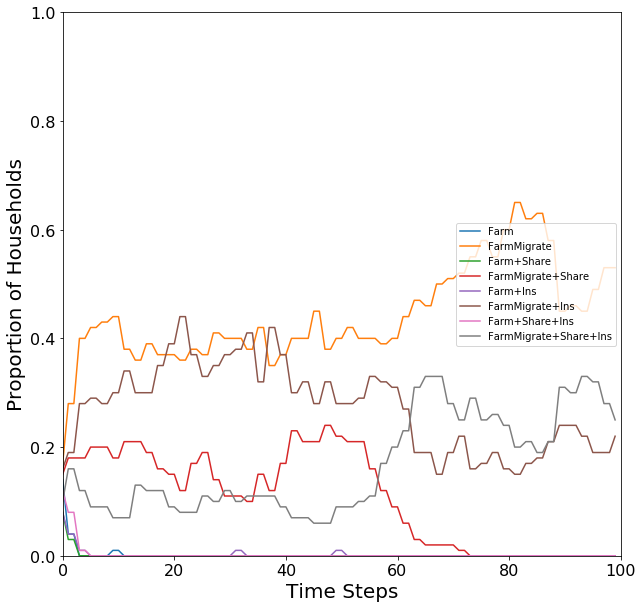

In [14]:
#Plot of strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}

for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros(time)


for t in range(time):
    for var_name, item in zip(local_variables.keys(), strategy_names):      
        local_variables[var_name][t] = sim_frequency_dist[0][t][item]

f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in local_variables.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend(loc = 'center right')
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])
ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('ExampleAltruism_alpha1.eps', bbox_inches='tight')


In [18]:
#Plot of average strategy distribution over time

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_proportion = {}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])
    
f, ax1 = plt.subplots(figsize=[10,10])
x = np.arange(time)
for key, value in avg_proportion.items():
    ax1.plot(x, value, label=key)

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()
ax1.set_ylim([0,1])
ax1.set_xlim([0, time])

ax1.set_xlabel('Time Steps', size=20)
ax1.set_ylabel('Proportion of Households', size=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#plt.savefig('Altruism05.eps', bbox_inches='tight')


NameError: name 'avg_time_proportion' is not defined

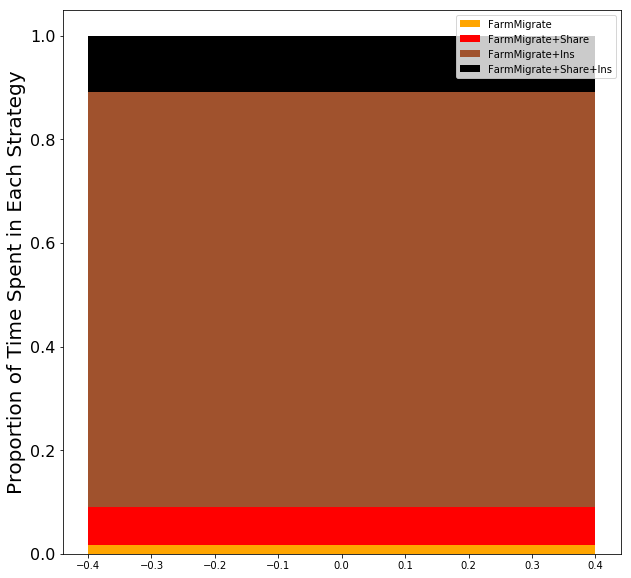

In [19]:
#Bar Graph of average strategy distributions over simulations

#Create arrays for proportion of households in any strategy over time

local_variables = {}
avg_time_proportion = {}
avg_proportion={}


for item in strategy_names:
    var_name = str(item)
    local_variables[var_name] = np.zeros((simulations,time))
    avg_time_proportion[var_name] = np.zeros(time)

for a in range(simulations):
    for t in range(time):
        for var_name, item in zip(local_variables.keys(), strategy_names):      
            local_variables[var_name][a,t] = sim_frequency_dist[a][t][item]

for var_name in local_variables.keys():
    for t in range(time):
        avg_time_proportion[var_name][t] = np.average(local_variables[var_name][:,t])
    
    avg_proportion[var_name] = np.average(avg_time_proportion[var_name])



f, ax = plt.subplots(figsize=[10,10])
x = np.arange(time)

categories = np.arange(1)
ax.bar(categories, avg_proportion['FarmMigrate'], label='FarmMigrate', color='orange')
ax.bar(categories, avg_proportion['FarmMigrate+Share'], bottom=avg_proportion['FarmMigrate'], label='FarmMigrate+Share', color='red')
ax.bar(categories, avg_proportion['FarmMigrate+Ins'], bottom=(avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Ins', color='sienna')
ax.bar(categories, avg_proportion['FarmMigrate+Share+Ins'], bottom=(avg_proportion['FarmMigrate+Ins'] + avg_proportion['FarmMigrate+Share'] + avg_proportion['FarmMigrate']), label='FarmMigrate+Share+Ins', color='black')

#ax1.plot(x, local_variables['FarmMigrate+Ins_prop'], linestyle='--')
#print(local_variables['FarmMigrate+Ins_prop'])
plt.legend()

#ax1.set_xlabel('Time Steps', size=20)
ax.set_ylabel('Proportion of Time Spent in Each Strategy', size=20)

plt.yticks(fontsize=16)
plt.show()

#np.save(avg_proportion, 'P0.3_proportion_10sim.npy')

#print(type(avg_proportion))
#data = json.dumps(avg_proportion)
#f = open("P0.01_proportion.json","w")
#f.write(data)
#f.close()

#plt.savefig('Altruism05_10sim.eps', bbox_inches='tight')

In [11]:
# Create Bar plot with separate bars for each drought probability tested

probabilities = [0.01, 0.05, 0.1, 0.3]
local_variables = {}
means = {'FarmMigrate':[], 'FarmMigrate+Share':[], 'FarmMigrate+Ins':[], 'FarmMigrate+Share+Ins':[]}



for item in probabilities:
    
    f = open('P' + str(item) + '_proportion.json',)
    var_name = ('p_' + str(item))
    local_variables[var_name] = json.load(f)
    f.close()


categories = means.keys()

for strategy in categories:
    for key,value in local_variables.items():
        means[strategy].append(local_variables[key][strategy])

probability_order = list(local_variables.keys())

f, ax = plt.subplots(figsize=[10,10])

bottom_1 = means['FarmMigrate']
bottom_2 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] for i in range(len(means['FarmMigrate']))]
bottom_3 = [means['FarmMigrate'][i] + means['FarmMigrate+Share'][i] + means['FarmMigrate+Ins'][i] for i in range(len(means['FarmMigrate']))]

#[test_list1[i] + test_list2[i] for i in range(len(test_list1))]
ax.bar(probability_order, means['FarmMigrate'], label = 'FarmMigrate', color='dodgerblue')
ax.bar(probability_order, means['FarmMigrate+Share'], bottom = bottom_1, label = 'FarmMigrate+Share', color='green')
ax.bar(probability_order, means['FarmMigrate+Ins'], bottom = bottom_2, label = 'FarmMigrate+Ins', color='salmon')
ax.bar(probability_order, means['FarmMigrate+Share+Ins'], bottom = bottom_3, label = 'FarmMigrate+Share+Ins', color='darkorchid')

ax.set_xlabel('Drought Probability', size=18)
ax.set_ylabel('Proportion of Time', size=18)


plt.legend(fontsize=16)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#plt.show()

plt.savefig('DroughtSensitivity.eps', bbox_inches='tight')

In [41]:
mu_farm_drought

NameError: name 'mu_farm_drought' is not defined